In [126]:
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

import copy
import math

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (12,8)

In [127]:
df = pd.read_csv(r"C:\Users\levir\OneDrive\Desktop\DataSets\SingaporeFlats.csv")

In [128]:
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200


In [129]:
# Digitizing all features for correlation matrix. (One-hot Encoding)
df_digitized = df

for col_name in df_digitized.columns:
    if(df_digitized[col_name].dtype == "object"):
        df_digitized[col_name] = df_digitized[col_name].astype("category")
        df_digitized[col_name] = df_digitized[col_name].cat.codes
df_digitized.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,0,0,0,269,4,3,31.0,2,1977,9000
1,0,0,0,269,4,1,31.0,2,1977,6000
2,0,0,0,269,4,3,31.0,2,1977,8000
3,0,0,0,269,4,2,31.0,2,1977,6000
4,0,0,2,147,4,1,73.0,8,1976,47200


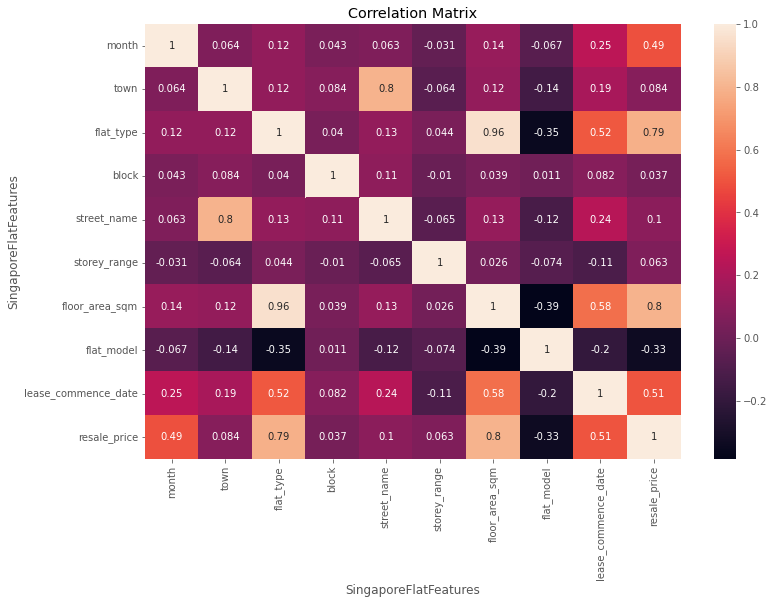

In [130]:
# Correlation Matrix
correlation_matrix = df_digitized.corr(method="pearson")
sns.heatmap(correlation_matrix, annot=True)
plt.title("Correlation Matrix")
plt.xlabel("SingaporeFlatFeatures")
plt.ylabel("SingaporeFlatFeatures")
plt.show()

In [35]:
# Looks like flat_type and floor_area_sqm have the most correlation with resale_price

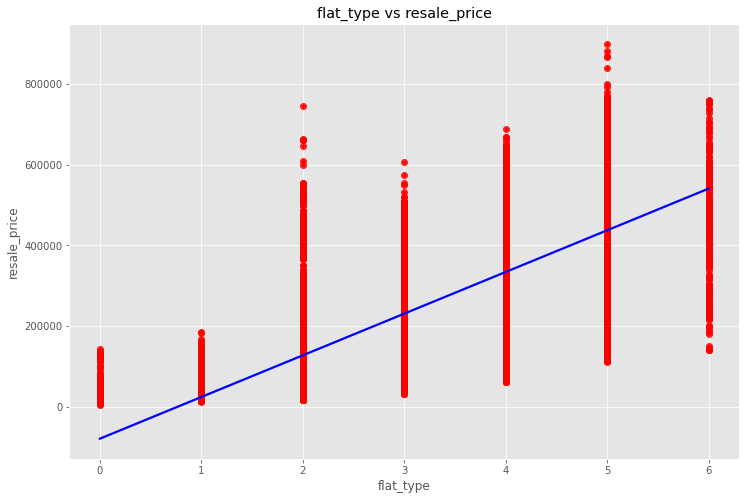

In [131]:
plt.scatter(x = df_digitized["flat_type"], y = df_digitized["resale_price"], marker = '.', c = 'r')
plt.title("flat_type vs resale_price")
plt.xlabel("flat_type")
plt.ylabel("resale_price")
sns.regplot(x="flat_type", y="resale_price", data=df_digitized, scatter_kws={"color":"red"}, line_kws={"color":"blue"})

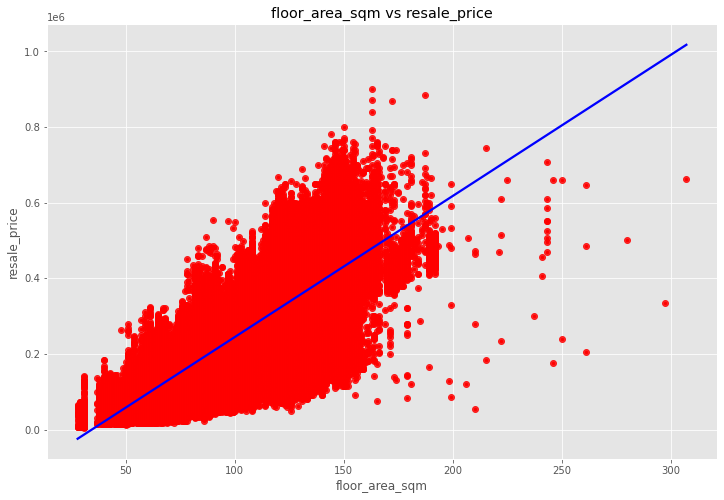

In [132]:
plt.scatter(x = df_digitized["floor_area_sqm"], y = df_digitized["resale_price"], marker = '.', c = 'r')
plt.title("floor_area_sqm vs resale_price")
plt.xlabel("floor_area_sqm")
plt.ylabel("resale_price")
sns.regplot(x="floor_area_sqm", y="resale_price", data=df_digitized, scatter_kws={"color":"red"}, line_kws={"color":"blue"})

Scores:  0.6419681597234269
Weights:  [ 2486.92088893 36541.78069278]


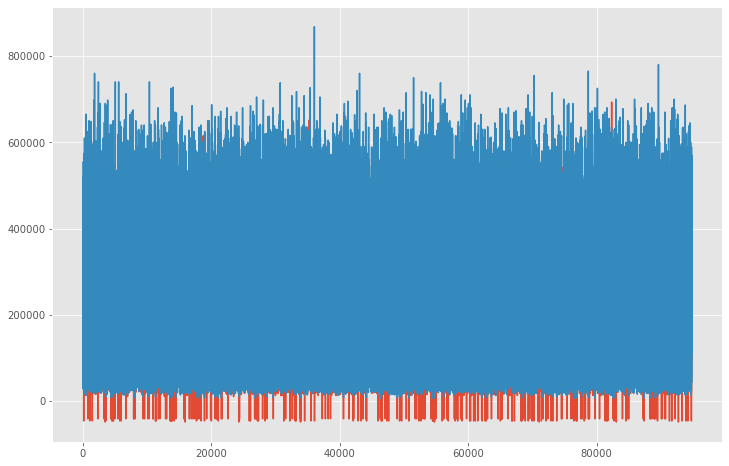

In [133]:
from sklearn.linear_model import LinearRegression

X = np.asarray(df_digitized[["floor_area_sqm", "flat_type"]])
#X = np.asarray(df[["floor_area_sqm"]])
Y = np.asarray(df_digitized["resale_price"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle= True)

lr = LinearRegression()
lr.fit(X_train, y_train)
print("Scores: ", lr.score(X_test, y_test))
print("Weights: ", lr.coef_)

plt.plot(lr.predict(X_test))
plt.plot(y_test)
plt.show()

In [154]:
#This time instead of doing a linear regression with only the two most correlated features to resale price we'll use almost all of them.
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y = df_digitized.resale_price.values
X = df_digitized[["town", "flat_type", "block", "street_name", "storey_range", "floor_area_sqm", "flat_model"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle= True)

lr = LinearRegression()
lr.fit(X_train, y_train)
yhat = lr.predict(X_test)

r2_score(y_test, yhat), mean_absolute_error(y_test, yhat), np.sqrt(mean_squared_error(y_test, yhat))

(0.6469897970950614, 58005.94894257743, 76191.47521724601)

In [155]:
# Using almost all of the given features for X only slightly improved our models prediction accuracy

In [156]:
# Now we'll try using a decision tree for predicting the resale value.

In [158]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
yhat2 = dt.predict(X_test)

r2_score(y_test, yhat2), mean_absolute_error(y_test, yhat2), np.sqrt(mean_squared_error(y_test, yhat2))

(0.584725615980527, 61532.38260004823, 82638.10028551659)

In [161]:
# The decision tree performed worse compared to the linear regression model. Having higher absolute and squared error values with a lower prediction accuracy.

In [162]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

#X = df_digitized[["town", "flat_type", "block", "street_name", "storey_range", "floor_area_sqm", "flat_model"]]
X = df_digitized[["town", "flat_type", "block", "street_name", "storey_range", "floor_area_sqm", "flat_model"]]

model = RandomForestRegressor()
ttr = TransformedTargetRegressor(regressor = model, transformer = QuantileTransformer(output_distribution="normal"))
ttr.fit(X_train, y_train)
yhat3 = ttr.predict(X_test)

r2_score(y_test, yhat3), mean_absolute_error(y_test, yhat3), np.sqrt(mean_squared_error(y_test, yhat3))


(0.6205979245147468, 59893.540391944334, 78988.27049081365)

In [163]:
# We have a slight reduction in error from the last decision tree model, yet, our performance isn't greater than the original linear regression.

In [164]:
# Now I'm going to try another version but with only key correlating features to what we want to predict.

In [165]:
X = df_digitized[["floor_area_sqm", "flat_type"]]

model = RandomForestRegressor()
ttr = TransformedTargetRegressor(regressor = model, transformer = QuantileTransformer(output_distribution="normal"))
ttr.fit(X_train, y_train)
yhat3 = ttr.predict(X_test)

r2_score(y_test, yhat3), mean_absolute_error(y_test, yhat3), np.sqrt(mean_squared_error(y_test, yhat3))


(0.620521281016023, 59903.88349929239, 78996.24834872439)

In [167]:
# Similar error and accuracy whilst decreasing features.
# In the end our final linear regression model using a testing size of .33 had a 64% price prediction accuracy with the lowest absolute and squared mean error.